# Load Oxford Street data

In [12]:
import cv2
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

## Data Loading 

In [2]:
data = pd.read_csv('CNN-to-Evaluate-Social-Distancing-Measures/02_data/Oxford_Data_at/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])
data.head(20)



,personNumber,frameNumber,headNumber,bodyNumber,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627
5,5,0,1,1,900.739,405.852,926.483,433.889,876.425,392.142,956.344,628.416
6,6,0,1,1,693.431,1028.397,736.904,1075.620,656.185,994.592,791.581,1387.335
7,7,0,1,1,1653.546,620.442,1686.481,655.497,1607.143,601.733,1717.096,892.799
8,8,0,1,1,1666.107,923.010,1710.000,968.739,1615.588,890.117,1748.101,1277.631
9,9,0,1,1,1832.710,183.865,1855.236,205.682,1790.455,174.285,1877.452,359.453


In [4]:
# Paths to files - adjust output directory for Google drive etc 
video_path = 'CNN-to-Evaluate-Social-Distancing-Measures/02_data/Oxford_Data/TownCentreXVID.mp4'
output_dir = '/Users/ninageyer/Library/CloudStorage/OneDrive-Personal/Dokumente/MScSEDS/2_DLSS/DLSS_project/OxfordTowncentre_data'

In [10]:
# Open the video file
cap = cv2.VideoCapture(video_path)

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Define the name and path for each frame
    frame_filename = os.path.join(output_dir, f'{frame_number}.jpg')
    
    # Save the frame as a JPG file
    cv2.imwrite(frame_filename, frame)
    
    frame_number += 1


cap.release()
cv2.destroyAllWindows()


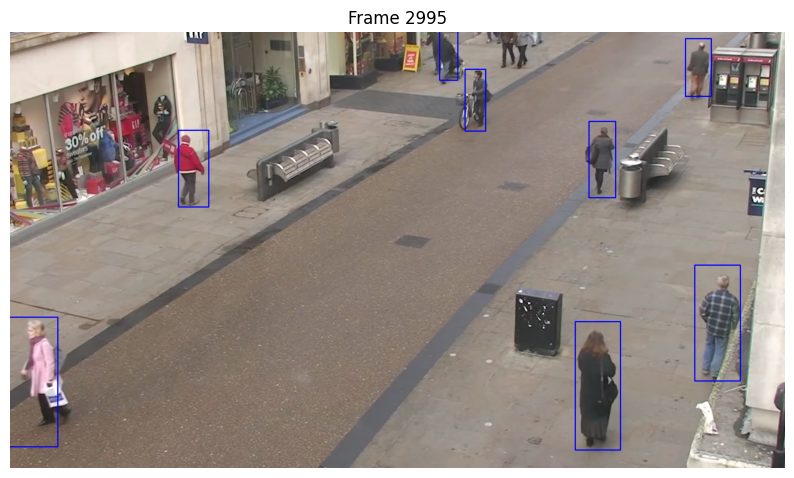

In [5]:
# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes):
    for box in boxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color bounding box
    return image

# Visualize images with bounding boxes
frames = data['frameNumber'].unique()
frames10 = frames[2995:2996]
for frame in frames10:
    frame = int(frame)
    image_path = os.path.join(output_dir, f'{frame}.jpg') 
    image = cv2.imread(image_path)
    
    if image is not None:
        # Extract bounding box coordinates for the current frame
        boxes = data[data['frameNumber'] == frame][['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']].values
        
        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(image, boxes)
        
        # Convert BGR image to RGB for matplotlib
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
        
        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Frame {frame}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for frame {frame} not found.")

## Data preprocessing 

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert the image to tensor
])

# Function to load an image and convert to tensor
def load_image_as_tensor(image_path):
    # Open image
    image = Image.open(image_path).convert('RGB')
    # Apply the transform to the image
    tensor_image = transform(image)
    return tensor_image

# Function to process a range of images
def process_images_in_range(image_folder, start_frame, end_frame):
    tensors = {}
    for frame in range(start_frame, end_frame + 1):
        image_path = os.path.join(image_folder, f'{frame}.jpg')  # Assuming images are named as frame numbers
        if os.path.exists(image_path):
            # Load the image and convert it to a tensor
            image_tensor = load_image_as_tensor(image_path)
            tensors[frame] = image_tensor
        else:
            print(f"Image for frame {frame} not found.")
    return tensors

# Function to display the tensor as an image
def show_image(tensor):
    # Convert tensor to numpy array and transpose to [H, W, C]
    np_image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

# Path to the folder containing images

start_frame = 1  # Starting frame number
end_frame = 3090   # Ending frame number

# Process images in the specified range
image_tensors = process_images_in_range(output_dir, start_frame, end_frame)



In [32]:
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, image, boxes=None):
        image = image.permute(1, 2, 0).numpy()
        h, w, _ = image.shape
        target_size = max(h, w)

        # Calculate scaling factor
        scale = target_size / max(h, w)
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h))

        # Calculate padding
        pad_w = (target_size - new_w) // 2
        pad_h = (target_size - new_h) // 2
        padded_image = cv2.copyMakeBorder(resized_image, pad_h, target_size - new_h - pad_h, pad_w, target_size - new_w - pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        if boxes is not None:
            # Adjust bounding boxes
            new_boxes = []
            for box in boxes:
                x1, y1, x2, y2, cls = box
                x1 = int(x1 * scale + pad_w)
                y1 = int(y1 * scale + pad_h)
                x2 = int(x2 * scale + pad_w)
                y2 = int(y2 * scale + pad_h)
                new_boxes.append([x1, y1, x2, y2, cls])
            return padded_image, np.array(new_boxes)
        
        return padded_image

    def inverse_transform(self, boxes, original_shape):
        h, w = original_shape[:2]
        target_size = max(h, w)

        # Calculate scaling factor
        scale = target_size / max(h, w)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Calculate padding
        pad_w = (target_size - new_w) // 2
        pad_h = (target_size - new_h) // 2

        # Reverse the transformations on bounding boxes
        original_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            x1 = int((x1 - pad_w) / scale)
            y1 = int((y1 - pad_h) / scale)
            x2 = int((x2 - pad_w) / scale)
            y2 = int((y2 - pad_h) / scale)
            original_boxes.append([x1, y1, x2, y2])
        return np.array(original_boxes)

## Data Loader 

In [65]:
 # Get bounding boxes for the current frame
annotations = data
annotations['class'] = 1
boxes = annotations[annotations['frameNumber'] == 1]
boxes = boxes[['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom', 'class']].values.astype('float').reshape(-1, 5)

In [11]:
image_tensors[1].shape

torch.Size([3, 1080, 1920])

In [8]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Stack images into a single tensor
    images = torch.stack(images, dim=0)
    
    # Pad targets to ensure they all have the same number of bounding boxes
    max_boxes = max([t.shape[0] for t in targets])
    padded_targets = []
    
    for t in targets:
        padded = torch.zeros((max_boxes, t.shape[1]))
        padded[:t.shape[0], :] = t
        padded_targets.append(padded)
    
    targets = torch.stack(padded_targets, dim=0)
    
    return images, targets

In [40]:
annotations = data
annotations['class'] = 1
annotations['confidence'] = 1

class TensorDataset(Dataset):
    def __init__(self, image_tensors, annotations, target_size):
        self.image_tensors = image_tensors
        self.annotations = annotations
        self.target_size = target_size
        self.transform = ResizeAndPad(self.target_size)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        frame_number = list(self.image_tensors.keys())[idx]
        image_tensor = self.image_tensors[frame_number]
        
        # Get bounding boxes for the current frame
        boxes = self.annotations[self.annotations['frameNumber'] == frame_number]
        if len(boxes) > 0:
            boxes = boxes[['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom', 'confidence','class']].values.astype('float')
        else:
            # If no bounding boxes, create a dummy box with zero values
            boxes = np.array([[0, 0, 0, 0, 0]], dtype='float')
        
        # Apply transform
        image_tensor, boxes = self.transform(image_tensor, boxes)
        
        # Convert image to tensor
        image_tensor = transforms.ToTensor()(image_tensor)
        
        return image_tensor, torch.tensor(boxes)



In [26]:
max(image_tensors[1].shape)

1920

In [41]:
# Get the list of frame numbers
frame_numbers = list(image_tensors.keys())

# Split the data into train and remaining (validation + test)
train_frames, val_test_frames = train_test_split(frame_numbers, test_size=0.3, random_state=42)

# Further split the remaining data into validation and test
val_frames, test_frames = train_test_split(val_test_frames, test_size=0.5, random_state=42)

# Create dictionaries for each split
train_tensors = {frame: image_tensors[frame] for frame in train_frames}
val_tensors = {frame: image_tensors[frame] for frame in val_frames}
test_tensors = {frame: image_tensors[frame] for frame in test_frames}

# target size 
target_size = max(image_tensors[1].shape)

# Create datasets for each split
train_dataset = TensorDataset(train_tensors, annotations, target_size)
val_dataset = TensorDataset(val_tensors, annotations, target_size)
test_dataset = TensorDataset(test_tensors, annotations, target_size)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)


## YOLO model definition

In [42]:
class YOLO(nn.Module):
    def __init__(self, num_classes, image_size=448):
        super(YOLO, self).__init__()
        self.num_classes = num_classes
        self.image_size = image_size
        
        # Define the layers of the model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        # Calculate the flattened size dynamically
        self.flattened_size = self._get_flattened_size(image_size)
        
        self.fc1 = nn.Linear(self.flattened_size, 4096)
        self.fc2 = nn.Linear(4096, 7 * 7 * (5 + self.num_classes))
    
    def _get_flattened_size(self, size):
        x = torch.zeros(1, 3, size, size)  # Create a dummy input
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = self.max_pool(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.leaky_relu(self.conv4(x))
        x = self.max_pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 7, 7, 5 + self.num_classes)  # Reshape to (batch, S, S, B*(5+num_classes))
        
        return x



## Model training 

In [38]:
for images, targets in train_loader:
        images = images.float()
        targets = targets.float()
        print(images.shape)
        print(targets.shape)
        break

torch.Size([32, 3, 1920, 1920])
torch.Size([32, 28, 5])


In [44]:
len(targets[0])

28

In [37]:
# Assuming the image size is known and defined (e.g., 448x448)
image_size = max(image_tensors[1].shape)
num_classes = 1  # Number of classes in your dataset
model = YOLO(num_classes=num_classes, image_size = image_size)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function (simplified for demonstration purposes)
criterion = nn.MSELoss()

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = images.float()
        targets = targets.float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader)}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.float()
            targets = targets.float()

            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader)}')


/Users/ninageyer/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 28, 5])) that is different to the input size (torch.Size([32, 7, 7, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 3

In [ ]:
def plot_image_with_boxes(image_tensor, boxes, title=None):
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert CHW to HWC
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for box in boxes:
        x1, y1, x2, y2, cls = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    if title:
        plt.title(title)
    plt.show()

# Load some samples from the test loader
transform = ResizeAndPad(target_size=target_size)
for images, targets in test_loader:
    for i in range(images.size(0)):
        image_tensor = images[i]
        boxes = targets[i].numpy()
        original_shape = (1080, 1920)  # Replace with your original shape
        
        # Forward pass to get predictions
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0))[0]
        
        # Extract predicted boxes
        pred_boxes = extract_boxes(output)
        
        # Inverse transform boxes
        true_boxes = transform.inverse_transform(boxes, original_shape)
        pred_boxes = transform.inverse_transform(pred_boxes, original_shape)
        
        # Plot image with true and predicted bounding boxes
        plot_image_with_boxes(image_tensor, true_boxes, pred_boxes, title="Test Image with Ground Truth and Predicted Boxes")
        
    break  # Just plot the first batch for illustration

In [ ]:
def predict(image, model, transform):
    # Apply transform to the image
    transformed_image = transform(image)
    
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(transformed_image).unsqueeze(0)
    
    # Predict bounding boxes
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
    
    # Get bounding boxes from the model output
    boxes = outputs[0].cpu().numpy()
    
    # Reverse the transform on bounding boxes
    original_boxes = transform.inverse_transform(boxes, image.shape)
    
    return original_boxes

# Example usage
image_path = 'path_to_your_image.jpg'
image = cv2.imread(image_path)
transform = ResizeAndPad(max(image.shape[:2]))
model = ...  # Load your trained model here

predicted_boxes = predict(image, model, transform)
print(predicted_boxes)